# Convolutional Neural Network applied to Transient Detection

Updates to use leaky ReLUs from Deep-HiTS paper...

In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

Put data loader into a function, break up potentially into train/valid/test subsets...

In [2]:
def load_pkl_data(chunk_num, split_frac=(0.8, 0.9), verbose=False):
    fname = 'all_chunks/chunk_%d_5000.pkl.gz' % chunk_num
    pkl_data = np.load(gzip.GzipFile(fname, 'rb'), encoding='bytes')
    if False:
        print(pkl_data.keys())
        print(pkl_data[b'diff_images'].shape)
    
    N_data = pkl_data[b'diff_images'].shape[0]
    if False:
        print(N_data)
    X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
                 pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
    X = np.swapaxes(X, 0, 1)

    Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
    if False:
        print(X.shape, Y.shape)
        
    N_train = int(N_data * split_frac[0])
    N_valid = 0
    if split_frac[0] < 1.0:
        N_valid = int(N_data * split_frac[1])
    N_test = 0
    if split_frac[1] < 1.0:
        N_test  = int(N_data * 1.0)

    X_train, Y_train = X[:N_train], Y[:N_train]
    X_valid = Y_valid = None
    if N_valid > 0:
        X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
    X_test = Y_test = None
    if N_test > 0:
        X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

    if verbose:
        print(np.mean(Y[:,0]), np.mean(Y[:,1]))
        print("Train: ", X_train.shape, Y_train.shape)
        if N_valid > 0:
            print("Valid: ", X_valid.shape, Y_valid.shape)
        if N_test > 0:
            print("Test: ", X_test.shape, Y_test.shape)
        
    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

We create a Keras sequential model and compile it.

In [3]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

# 0.04 and 0.5 and 1./100000 are params from Deep-HiTS paper
# decay = "reduced by half every 100,000 iterations"
def make_model(compile=True, epochs=100, lrate=0.04, dropout=0.5, decay=1./100000.,
              momentum=0.0, use_leaky=True):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    if not use_leaky:
        model.add(Convolution2D(32, (4, 4), activation='relu'))
    else:
        model.add(Convolution2D(32, (4, 4)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(32, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(32, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    if not use_leaky:
        model.add(Dense(64, activation='relu'))
    else:
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
    if dropout is not None:
        model.add(Dropout(dropout))
    if not use_leaky:
        model.add(Dense(64, activation='relu'))
    else:
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        # model.compile(loss='mean_squared_error',
        #       optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        #epochs = 25
        #lrate = 0.01
        if decay is None:
            if epochs > 2:
                decay = lrate/epochs
            else:
                decay = lrate/100.
        opt = keras.optimizers.SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)

        # Let's train the model using RMSprop
        model.compile(loss='mean_squared_error', #categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [4]:
model = make_model(epochs=25)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 24, 24)        2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
__________

Now, we fit our model to the training data-set

In [7]:
def run_model(model, train, valid, epochs=25, batch_size=32, data_augmentation=True, 
              patience=5, **kwargs):
    X_train, Y_train = train
    X_valid, Y_valid = valid
    
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    if not data_augmentation:
        if epochs > 2:
            print('Not using data augmentation.')
        histry = model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping], **kwargs)
    else:
        if epochs > 2:
            print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        # datagen.fit(X_train)  # so not needed.

        # Fit the model on the batches generated by datagen.flow().
        histry = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping], **kwargs) 
        
    return model, histry

In [19]:
def plot_misclassified(model, ypred, X_test, Y_test, nmax=10, only_plot_misclassified=True):
    ytest = Y_test[:, 1].astype(int)

    N_plot = nmax
    only_plot_wrong = only_plot_misclassified
    if not only_plot_wrong:
        plot_inds = range(N_plot)
    else:
        plot_inds = np.where(ypred != ytest)[0]
        print("Incorrectly classified: %d of %d" % (len(plot_inds), len(ypred)))
        if len(plot_inds) > N_plot:
            plot_inds = plot_inds[:N_plot]
    N_plot = len(plot_inds)

    plt.clf()
    fig, axes = plt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                            subplot_kw={'xticks': [], 'yticks': []})
    i = 0
    for ind in plot_inds:
        axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
        axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
        axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
        axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

        axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                      ", label = " + str(ytest[ind]))
        i += 1
    plt.show()

Now try fitting a large number of data in batches:

Try using `fit_generator()` with a data generator.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# This will do preprocessing and realtime data augmentation.
# Here we only do flips. This keeps things like bad columns vertical.
imageDatagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

In [29]:
batch_size = 32
seed = 666

def data_generator_train():
    data_range = np.arange(150)  # use inds 0-150 for training
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' TRAIN:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size):  # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

# Question: Do we want to use the imageDatagen on validation and test data???
# Let's say, no, so make a new data generator that basically does nothing except make batches.
# Note these are all the default parameters, so `ImageDataGenerator()` would work too.

validTestDataGen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

def data_generator_valid():
    data_range = np.arange(151, 235)  # use inds 151-234 for validation
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' VALID:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = validTestDataGen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)
        
# Then we can use inds 235-284 as test data.
def data_generator_test():
    data_range = np.arange(235, 285)  # use inds 235-284 for test
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' TEST:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = validTestDataGen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

Trick to get this to work is make `steps_per_epoch` greater than (or approx. equal to)  `X.shape[0]//batch_size` so that it reads in multiple data sets per epoch. The point is, don't make `steps_per_epoch` too small, or it will only work on a few data sets over many epochs. Then make `validation_steps` also be big to use many batches of validation data (probably want it to also be greater than `X.shape[0]//batch_size`).

In [7]:
# Here's an example of how to track the learning rate.
# Taken from here: https://github.com/fchollet/keras/issues/2823

import keras.backend as kbackend

class SGDLearningRateTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = kbackend.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print('\nLR: {:.6f}\n'.format(lr))

In [13]:
np.random.seed(seed)

epochs = 10000
model = make_model(compile=True, epochs=epochs, lrate=0.04, decay=1./100000.)

train_generator = data_generator_train()
valid_generator = data_generator_valid()

from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=1000)
checkpointing = ModelCheckpoint('model.{epoch:05d}-{val_loss:.6f}.hdf5', #''./best_model.hdf5', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True, save_weights_only=False, 
                                mode='auto', period=1)

rateChecking = SGDLearningRateTracker()

# steps_per_epoch=5000: 5000/32=156 chunks trained per epoch,
# then validation_steps=500: 500/32=15.6 chunks tested per epoch
model.fit_generator(generator=train_generator, 
                    validation_data = valid_generator, validation_steps=500,
                    #datagen.flow(X_train, Y_train, batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=5000,
                    callbacks=[early_stopping, checkpointing, rateChecking], workers=1)

 TRAIN:Epoch 1/10000 
17
4999/5000 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9683 VALID: 159
 VALID: 207
 VALID: 194
 VALID: 181
Epoch 00000: val_loss improved from inf to 0.01753, saving model to ./best_model.hdf5

LR: 0.038095

5000/5000 [==============================] - 1405s - loss: 0.0282 - acc: 0.9683 - val_loss: 0.0175 - val_acc: 0.9811
Epoch 2/10000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9808 VALID: 220
 VALID: 220
 VALID: 188
Epoch 00001: val_loss improved from 0.01753 to 0.01386, saving model to ./best_model.hdf5

LR: 0.036364

5000/5000 [==============================] - 1350s - loss: 0.0179 - acc: 0.9807 - val_loss: 0.0139 - val_acc: 0.9834
Epoch 3/10000
2474/5000 [=============>................] - ETA: 686s - loss: 0.0150 - acc: 0.9835 TRAIN: 129


4999/5000 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9827 VALID: 205
 VALID: 219
 VALID: 166
Epoch 00002: val_loss improved from 0.01386 to 0.01280, saving model to ./best_model.hdf5

LR: 0.034783

5000/5000 [==============================] - 1365s - loss: 0.0158 - acc: 0.9827 - val_loss: 0.0128 - val_acc: 0.9861
Epoch 4/10000
 TRAIN: 98
 113/5000 [..............................] - ETA: 1158s - loss: 0.0102 - acc: 0.9878

KeyboardInterrupt: 

In [8]:
model = keras.models.load_model('./best_model.hdf5')  # Link your favorite model to this name

In [28]:
test_generator = data_generator_test()
score = model.evaluate_generator(test_generator, steps=1500)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 TEST: 242
 TEST: 264
 TEST: 262
 TEST: 281
 TEST: 258
 TEST: 273
 TEST: 269
 TEST: 280
 TEST: 251
 TEST: 273
Test loss: 0.00623168985175
Test accuracy: 0.992708333333


Load multiple test data sets for evaluation...

Need many data points to get high-resolution in DET plot below...

In [31]:
# Make sure we don't take too much RAM:

X_test = Y_test = None
for i in range(235, 255):
    (X, Y), _, _ = load_pkl_data(i, split_frac=(1.0, 1.0), verbose=False)
    if X_test is None:
        X_test, Y_test = X, Y
    else:
        X_test = np.concatenate((X_test, X), 0)
        Y_test = np.concatenate((Y_test, Y), 0)
    print(i, X_test.shape, X_test.nbytes/1024/1024)  # in MB

235 (5120, 4, 21, 21) 68.90625
236 (10190, 4, 21, 21) 137.13958740234375
237 (15204, 4, 21, 21) 204.6192626953125
238 (20252, 4, 21, 21) 272.5565185546875
239 (25356, 4, 21, 21) 341.2474365234375
240 (30538, 4, 21, 21) 410.98809814453125
241 (35624, 4, 21, 21) 479.436767578125
242 (40656, 4, 21, 21) 547.15869140625
243 (45656, 4, 21, 21) 614.449951171875
244 (50782, 4, 21, 21) 683.4369506835938
245 (55796, 4, 21, 21) 750.9166259765625
246 (60978, 4, 21, 21) 820.6572875976562
247 (66058, 4, 21, 21) 889.0252075195312
248 (71066, 4, 21, 21) 956.4241333007812
249 (76106, 4, 21, 21) 1024.2537231445312
250 (81164, 4, 21, 21) 1092.3255615234375
251 (86258, 4, 21, 21) 1160.8818969726562
252 (91304, 4, 21, 21) 1228.792236328125
253 (96486, 4, 21, 21) 1298.5328979492188
254 (101500, 4, 21, 21) 1366.0125732421875
255 (106618, 4, 21, 21) 1434.8919067382812
256 (111772, 4, 21, 21) 1504.2557373046875
257 (116796, 4, 21, 21) 1571.8699951171875
258 (121852, 4, 21, 21) 1639.9149169921875
259 (126862, 4

In [32]:
from sklearn import metrics

pred = model.predict_proba(X_test)
pred_classes = np.argmax(pred, 1)

print(metrics.classification_report(Y_test[:,1].astype(int), pred_classes, digits=6))

202580/202580 [==============================] - 767s   
             precision    recall  f1-score   support

          0   0.995172  0.991046  0.993104    101290
          1   0.991082  0.995192  0.993133    101290

avg / total   0.993127  0.993119  0.993119    202580



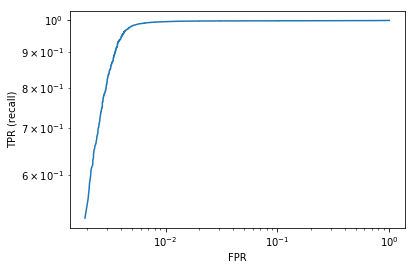

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1], pred[:,1])
plt.loglog(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

Incorrectly classified: 1394 of 202580


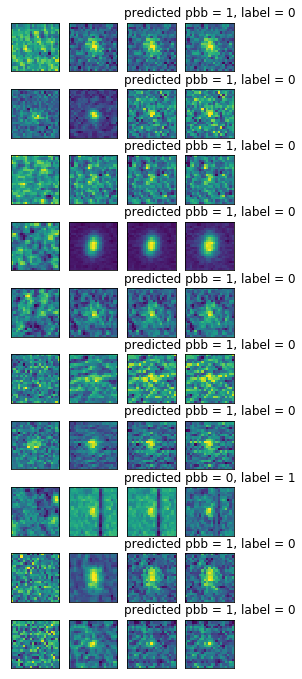

In [34]:
plot_misclassified(model, pred_classes, X_test, Y_test, nmax=10, only_plot_misclassified=True)

Make a "DET" curve (detection error trade-off) plot as in the paper...

Code not in sklearn yet, but from [this PR](https://github.com/scikit-learn/scikit-learn/pull/4980)

In [21]:
import sklearn.utils

def _binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    """Calculate true and false positives per binary classification threshold.
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        True targets of binary classification
    y_score : array, shape = [n_samples]
        Estimated probabilities or decision function
    pos_label : int, optional (default=None)
        The label of the positive class
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    Returns
    -------
    fps : array, shape = [n_thresholds]
        A count of false positives, at index i being the number of negative
        samples assigned a score >= thresholds[i]. The total number of
        negative samples is equal to fps[-1] (thus true negatives are given by
        fps[-1] - fps).
    tps : array, shape = [n_thresholds := len(np.unique(y_score))]
        An increasing count of true positives, at index i being the number
        of positive samples assigned a score >= thresholds[i]. The total
        number of positive samples is equal to tps[-1] (thus false negatives
        are given by tps[-1] - tps).
    thresholds : array, shape = [n_thresholds]
        Decreasing score values.
    """
    sklearn.utils.check_consistent_length(y_true, y_score)
    y_true = sklearn.utils.column_or_1d(y_true)
    y_score = sklearn.utils.column_or_1d(y_score)
    if sample_weight is not None:
        sample_weight = sklearn.utils.column_or_1d(sample_weight)

    # ensure binary classification if pos_label is not specified
    classes = np.unique(y_true)
    if (pos_label is None and
        not (np.all(classes == [0, 1]) or
             np.all(classes == [-1, 1]) or
             np.all(classes == [0]) or
             np.all(classes == [-1]) or
             np.all(classes == [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    if sample_weight is not None:
        weight = sample_weight[desc_score_indices]
    else:
        weight = 1.

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    # We need to use isclose to avoid spurious repeated thresholds
    # stemming from floating point roundoff errors.
    distinct_value_indices = np.where(np.logical_not(np.isclose(
        np.diff(y_score), 0)))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = (y_true * weight).cumsum()[threshold_idxs]
    if sample_weight is not None:
        fps = weight.cumsum()[threshold_idxs] - tps
    else:
        fps = 1 + threshold_idxs - tps
    return fps, tps, y_score[threshold_idxs]

def detection_error_tradeoff(y_true, probas_pred, pos_label=None,
                             sample_weight=None):
    """Compute error rates for different probability thresholds
    Note: this implementation is restricted to the binary classification task.
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        True targets of binary classification in range {-1, 1} or {0, 1}.
    probas_pred : array, shape = [n_samples]
        Estimated probabilities or decision function.
    pos_label : int, optional (default=None)
        The label of the positive class
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    Returns
    -------
    fps : array, shape = [n_thresholds]
        A count of false positives, at index i being the number of negative
        samples assigned a score >= thresholds[i]. The total number of
        negative samples is equal to fps[-1] (thus true negatives are given by
        fps[-1] - fps).
    fns : array, shape = [n_thresholds]
        A count of false negatives, at index i being the number of positive
        samples assigned a score < thresholds[i]. The total number of
        positive samples is equal to tps[-1] (thus false negatives are given by
        tps[-1] - tps).
    thresholds : array, shape = [n_thresholds]
        Decreasing score values.
    References
    ----------
    .. [1] `Wikipedia entry for Detection error tradeoff
            <https://en.wikipedia.org/wiki/Detection_error_tradeoff>`_
    .. [2] `The DET Curve in Assessment of Detection Task Performance
            <http://www.itl.nist.gov/iad/mig/publications/storage_paper/det.pdf>`_
    .. [3] `2008 NIST Speaker Recognition Evaluation Results
            <http://www.itl.nist.gov/iad/mig/tests/sre/2008/official_results/>`_
    .. [4] `DET-Curve Plotting software for use with MATLAB
            <http://www.itl.nist.gov/iad/mig/tools/DETware_v2.1.targz.htm>`_
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.metrics import detection_error_tradeoff
    >>> y_true = np.array([0, 0, 1, 1])
    >>> y_scores = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fps, fns, thresholds = detection_error_tradeoff(y_true, y_scores)
    >>> fps
    array([ 0.5,  0.5,  0. ])
    >>> fns
    array([ 0. ,  0.5,  0.5])
    >>> thresholds
    array([ 0.35,  0.4 ,  0.8 ])
    """
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred,
                                             pos_label=pos_label,
                                             sample_weight=sample_weight)
    fns = tps[-1] - tps
    tp_count = tps[-1]
    tn_count = (fps[-1] - fps)[0]

    # start with false positives is zero and stop with false negatives zero
    # and reverse the outputs so list of false positives is decreasing
    last_ind = tps.searchsorted(tps[-1]) + 1
    first_ind = fps[::-1].searchsorted(fps[0])
    sl = range(first_ind, last_ind)[::-1]
    return fps[sl] / tp_count, fns[sl] / tn_count, thresholds[sl]

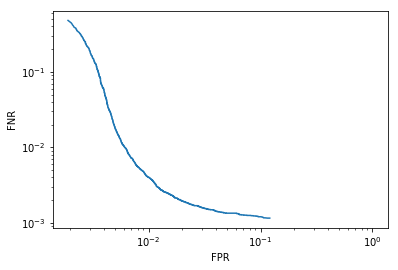

In [35]:
fpr, fnr, thresholds = detection_error_tradeoff(Y_test[:,1], pred[:,1])
plt.loglog(fpr, fnr, label='DET Curve')
#plt.xlim(1e-5, 0.5); plt.ylim(1e-5, 0.5)
plt.xlabel('FPR'); plt.ylabel('FNR')

Try re-starting a loaded model...  seems to work. But how to start it at its old iteration?

Looks like we use the `inital_epoch` parameter for `fit_generator`.